# Introduzione al word vector

[link al corso](https://www.youtube.com/playlist?list=PLoROMvodv4rOSH4v6133s9LFPRHjEmbmJ)
[libro](https://github.com/practical-nlp/practical-nlp-code)



## Cosa speriamo di imparare

* le fondamenta dei metodi di deep learning applicati al problema NLP
* una immagine di insieme sulla comprensione del linguaggio umano e sulla difficoltà di comprensione e rappresentazione in un computer
* la comprensione di come costruire sistemi tramite (PyTorch) per alcuni dei maggiori problemi di NLP come ad esempio: 
    * Word meaning, 
    * dependency parsing, 
    * machine translation, 
    * question answering

Il linguaggio umano è un sistema sociale, costruito e interpretato dalle persone.
Non è un sistema formale bensi un glorioso caos, costruito dagli umani.

Il primo passo interessante è stato il modello GPT-3 perchè è il primo oggetto che potremmo chiamare modello universale.
Questo modello estremamente grande è stato addestrato su una serie di dati molto grande (wikipedia) e al suo interno contiene infomazioni circa l'attività che deve svolgere (contesto), si può dunque usarlo per fargli eseguire molte attività.

In questo modo non dobbiamo costruire ogni volta un modello per rilevare lo spam, linguaggio non consueto, un modello per ogni lingua. 
Abbiamo uno strumento che capisce da solo cosa fare.

Tutto questo partendo da un modello che esegue la previsione di una parola che segue delle altre parole.

## Come rappresentiamo il significato di un testo/parola?

Definizione di **significato**:

* L'idea che è rappresentata da una parola, frase ecc ecc
* L'idea che una persona vuole esprimere usando parole, segni ecc ecc 
* L'idea che viene espressa in un lavoro di scrittura, arte ecc ecc
    
Il modo linguistico più comune per rappresentare il significato:

significante (simbolo) $\leftrightarrow$ significato (idea o cosa)

![significato](./images/significato.png)

questo modello non è facilmente implementabile in un computer ad esempio come posso implementare in un computer il concetto/simbolo di una sedia?

Quindi tradizionalmente il modo in cui il concetto è stato rappresentato normalmente gestito nei sistemi di elborazione del linguaggio naturale è stato quello di utilizzare risorse come ad esempio un dizionario.

Questi dizionari contengono liste di insiemi di sinonimi e [iperonimi](https://www.treccani.it/enciclopedia/iperonimi_%28Enciclopedia-dell%27Italiano%29/).

qui un insieme di sinonimi per "good"

In [3]:
from nltk.corpus import wordnet as wn
import nltk

#nltk.download('wordnet')

word = "good"
#word = "ninja"

poses = { 'n':'noun', 'v':'verb', 's':'adj (s)', 'a':'adj', 'r':'adv'}
for synset in wn.synsets(word):
    print("{}: {}".format(poses[synset.pos()],", ".join([l.name() for l in synset.lemmas()])))

noun: good
noun: good, goodness
noun: good, goodness
noun: commodity, trade_good, good
adj: good
adj (s): full, good
adj: good
adj (s): estimable, good, honorable, respectable
adj (s): beneficial, good
adj (s): good
adj (s): good, just, upright
adj (s): adept, expert, good, practiced, proficient, skillful, skilful
adj (s): good
adj (s): dear, good, near
adj (s): dependable, good, safe, secure
adj (s): good, right, ripe
adj (s): good, well
adj (s): effective, good, in_effect, in_force
adj (s): good
adj (s): good, serious
adj (s): good, sound
adj (s): good, salutary
adj (s): good, honest
adj (s): good, undecomposed, unspoiled, unspoilt
adj (s): good
adv: well, good
adv: thoroughly, soundly, good


qui gli iperonimi di "panda"

In [4]:
from nltk.corpus import wordnet as wn

panda = wn.synset("panda.n.01")
hyper = lambda s: s.hypernyms()
list(panda.closure(hyper))

[Synset('procyonid.n.01'),
 Synset('carnivore.n.01'),
 Synset('placental.n.01'),
 Synset('mammal.n.01'),
 Synset('vertebrate.n.01'),
 Synset('chordate.n.01'),
 Synset('animal.n.01'),
 Synset('organism.n.01'),
 Synset('living_thing.n.01'),
 Synset('whole.n.02'),
 Synset('object.n.01'),
 Synset('physical_entity.n.01'),
 Synset('entity.n.01')]

Questa è un'ottima risorsa per i problemi di NLP ma abbiamo un problemino.
Non riusciamo a catturare alcune sfumature:

* ad esempio “proficient” (competente) è segnato come sinonimo per "good" (buono) ma questo è vero solo in alcuni contesti
* questo sistema elenca i sinonimi offensivi senza nessuna copertura delle annotazioni o appropriatezza delle parole
* mancano i significati delle nuove parole ad esempio: wicked, badass, nifty, wizard, genius, ninja, bombest è impossibile tenerlo sempre aggiornato
* è soggettivo
* richiede del lavoro umano per aggiornarlo e adattarlo
* non può essere usato per ottenere parole simili con accuratezza

## Rappresentazione del testo 

Come abbiamo intuito da prima il testo deve essere convertito in una rappresentazione matematica, rappresenteremo il testo come vettori di numeri.

Vogliamo inoltre che dati due vettori $A$ e $B$ definiamo il concetto di similarità come il coseno di similitudine:

$$ \text{similarity} = \cos(\theta ) = \frac{A \cdot B}{\lVert  A  \rVert_2 \lVert  B  \rVert_2 }$$


![similarity](./images/two_vectors.png)

creiamo un dataset giocattolo per capire il concetto.


In [5]:
documents = ["Dog bites man.", "Man bites dog.", "Dog eats meat.", "Man eats food."]
processed_docs = [doc.lower().replace(".","") for doc in documents]
processed_docs

['dog bites man', 'man bites dog', 'dog eats meat', 'man eats food']

dal testo mi creo il vocabolario

In [6]:
vocab = {}
count = 0
for doc in processed_docs:
    for word in doc.split():
        if word not in vocab:
            count = count +1
            vocab[word] = count
print(vocab)

{'dog': 1, 'bites': 2, 'man': 3, 'eats': 4, 'meat': 5, 'food': 6}


nei problemi di NLP consideriamo le parole come simboli discreti, ogni simbolo di una parola è rappresentata da un vettore con il valore 1 in una posizione (vedi le parole sopra) e zero in tutti gli altri elementi.

In [7]:
def get_onehot_vector(somestring):
    onehot_encoded = []
    for word in somestring.split():
        temp = [0]*len(vocab)
        if word in vocab:
            temp[vocab[word]-1] = 1 # -1 is to take care of the fact indexing in array starts from 0 and not 1
        onehot_encoded.append(temp)
    return onehot_encoded

In [8]:
print(processed_docs[1])
get_onehot_vector(processed_docs[1]) #one hot representation for a text from our corpus.

man bites dog


[[0, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]]

come si vede il primo problema è legato al fatto che il vocabolario può essere molto grande e il nostro vettore può arrivare ad avere dimensione anche di 500000 elementi.

Inoltre questa rappresentazione presenta un ulteriore problema, non riusciamo a rappresentare una relazione tra le parole (similitudine) in quanto i vettori sono ortogonali.

Dobbiamo trovare un sistema per codificare la similitudine nei vettori.

## Rappresentare le parole dal loro contesto
Questo ci porta alla [semantica distribuzionale](https://it.wikipedia.org/wiki/Semantica_distribuzionale) in cui diciamo che il **significato di una parola** viene dato dalle parole che spesso appaiono nelle sue vicinanze.

    Conoscerai una parola dalla compagnia che frequenta.
     J. R. Firth (1890 – 1960)

Rappresenta una delle idee di successo all'approccio moderno alla NLP.
Quando una parola *w* appare nel testo il suo **contesto** è l'insieme di parole che appaiono nelle vicinanze, in una finestra di dimensione fisse

![contesto](./images/context.png)


L'oggetto che andremo a costruire sarà rappresentato dal *word vector* un vettore denso per ogni parola scelto in modo che parole simili ottengano vettori simili come ad esempio :

In [9]:
import numpy as np
banking = np.asarray([0.286,0.792,-0.177,-0.107,0.109,-0.542,0.349,0.271])
monetary = np.asarray([0.413,0.582,-0.007,0.247,0.216,-0.718,0.147,0.051])

np.dot(banking, monetary) / (np.linalg.norm(banking) * np.linalg.norm(monetary))

0.8570493105815338

i vettori sopra sono a 8 dimensioni per semplicità ma di solito si arriva ad una dimensione pari a 300
i word vectors sono anche chiamati embeddings o word representations, sono rappresentazioni distribuite.

## Introduzione a word2vec

iniziamo ad introdurre l'algoritmo Word2vec (Mikolov et al. 2013) che rappresenta il primo sistema per estrarre dal testo questi vettori.

L'algoritmo parte dall'idea che abbiamo a disposizione un sacco di testo che chiameremo (corpus) da quello per per ogni parola parola in un vocabolario fisso viene rappresentata da un vettore. 

Passiamo poi ogni posizione del testo *t*, con una parola centrale *c* ed un contesto di parole *o*. 
Usiamo la somiglianza dei word vector di *c* e *o* per calcolare la probabilità di *o* dato *c* o viceversa

Aggiustiamo i valori del word vector al fine di massimizzare la probabilità.
Otterremo dunque un insieme di vettori uno per ogni parola di quel testo.

Qui sotto un esempio del calcolo della probabilità $P(w_{t+j}|w_t)$ (si legge Probabilità di $w_{t+j}$ dato $w_t$)
![window](./images/window.png)


### Funzione obiettivo
Il nostro scopo è quello di creare un modello i cui parametri siano i **word vectors**, poi si esegue l'addestramento del modello su un certo obiettivo.
Ad ogni iterazione eseguiamo il nostro modello, valutiamo gli errori ed seguiamo una regola che conosce come penalizzare i parametri del modello che hanno creato questi errori. Alla fine abbiamo i nostri **word vectors**.

Sono stati provati molti approcci, qui vediamo un approccio *word2vec* che include:

* 2 algoritmi continuous bag-of-words (CBOW) e skip-gram, CBOW mira a predirre la parola centrale partendo dal contesto, mentre skip-gram fa esattamente il contrario, prevede la distribuzione (probabilità) delle parole del contesto partendo dalla parola centrale

* 2 sistemi di training negative sampling e hierarchical softmax. Nel negative sampling definiamo un obiettivo campionando gli esempi negativi mentre nel hierarchical softmax usiamo una funzione ad albero efficiente per calcolare la probabilità di ogni parola nel vocabolario.

Dobbiamo dunque creare un modello che assegna una probabilità ad ogni sequenza di token. 
Prendiamo la frase *"The cat jumped over the puddle."* un buon modello darà una probabilità alta alla seguente frase in quanto la frase è valida (sintatticamente e semanticamente).

Similmente il modello dovrà dare una bassa probabilità alla frase *"stock boil fish is toy"* in quanto questa non ha senso.
Matematicamente possiamo scrivere questa sequenza di parole come:

$$P(w_1,w_2,...,w_n)$$

Per calcolare questa probabilità possiamo partire da un modello semplice detto unigram il quale assume che le parole non sono correlate tra di loro:

$$P(w_1,w_2,...,w_n) = \prod_{i=1}^{n} P(w_{i})$$

Tuttavia si vede subito che questo modello è ridicolo in quanto la parola seguente dipende fortemente dalle parole antecedenti.
Infatto la seconda frase con questo modello avrà un punteggio elevato. 

Cambiamo modello e definiamo che la probabilità della frase dipende dalle probabilità delle coppie nella frase (parola antecedente e successiva), chiamiamo questo modello bigram

$$P(w_1,w_2,...,w_n) = \prod_{i=2}^{n} P(w_{i}|w_{i-1})$$

Anche questo è un modello un pochino ingenuo, ci stiamo concentrando solo sulle coppie e non sull'intera frase.
Vedremo più avanti però che questa rappresentazione può essere espansa.


### Continuous Bag of Words Model (CBOW)

Prendendo la frase *"The cat jumped over the puddle."* il primo approccio è quello di predire la parola *jumped* partendo dal contesto *["the","cat","over","the"]* questo modello viene chiamato continuous bag of word.

Vediamo i parametri conosciuti del modello, in ingresso ed in uscita abbiamo le parole codificate tramite *one-hot vectors*. I vettori in ingresso (contesto) verranno rappresentati con il simbolo $x^{c}$, l'output verrà rappresentato come $y^{c}$.
Nel modello CBOW visto che il risultato è univoco possiamo scrivere tranquillamente il risultato come $y$.

Definiamo ora le variabili sconosciute del modello, creiamo due matrici, $\mathcal{V} \in \mathbb{R}^{n \times |V|}$ e $\mathcal{U} \in \mathbb{R}^{|V| \times n}$, $n$ viene scelto in modo arbitrario e rappresenta il nostro spazio di embeddings.

$\mathcal{V}$ rappresenta la matrice delle parole di input tale che la $i$-esima colonna di $\mathcal{V}$ è la rappresentazione a dimensione $n$ della parola $w_{i}$ quando questa è un input del modello. 

Si denota questo vettore come $\mathcal{v}_i$

Similmente $\mathcal{U}$ rappresenta la matrice delle parole in output la $j$-esima colonna di $\mathcal{U}$ rappresenta il vettore di embeddings $\mathcal{u}_j$ quando la parola $w_{j}$ è un output del modello.

Notiamo subito che andremo a creare due vettori per rappresentare la stessa parola $w_{i}$ ($\mathcal{v}_i$ e  $\mathcal{u}_i$).
Analizziamo come funziona il modello in questi passaggi:


1. andiamo a generare un one-hot vectors per ogni parola del contesto di input di dimensione m: $(x^{c-m},\cdots,x^{c-1},x^{c+1},x^{c+m}) \in  \mathbb{R}^{|V|}$

2. andiamo ad ottenere i word-vectors del contesto moltiplicando i vettori $x$ per $\mathcal{V}$

3. eseguiamo la media e otteniamo il vettore $\mathcal{\hat{v}}$

4. generiamo il vettore dei punteggi $\mathcal{z} = \mathcal{U} \cdot \mathcal{\hat{v}}$ 

5. trasformiamo i punteggi in probabilità $\hat{y} = softmax(z) \in \mathbb{R}^{|V|}$.

6. quello che desideriamo è che le probabilità generate $\hat{y}$ vadano a combaciare con la probabilità vera $y$ il vettore one-hot della parola attuale

Abbiamo compreso ora come sarebbe il modello se avessimo $\mathcal{U}$ e $\mathcal{V}$ ma come si ottengono queste due matrici?
Prima cosa dobbiamo creare la funzione obiettivo, in questo caso siamo fortunati ci troveremo spesso a dover trattare una probabilità calcolata e una probabilità reale.

Come si misura la distanza tra due distibuzioni? 
La risposta sta nella cross-entropy (entropia incrociata) $H(\hat{y},y)$.

Nel caso discreto la formula 

$$H(\hat{y},y) = -\sum_{j=1}^{|V|}y_j log(\hat{y}_j)$$

Occupiamoci del caso in questione, con $y$ vettore one-hot che semplifica la formula:

$$H(\hat{y},y) = -y_j log(\hat{y}_j)$$

Partiamo con il caso in cui la previsione sia corretta, diciamo che $c$ è l'indice della parola nel vettore one-hot che vogliamo ottenere dunque se la previsione è corretta avremo che $\hat{y}_c = 1$. In questo caso la formula sarà:

$$H(\hat{y},y) = -1 log(1) = 0$$

Per una previsione corretta abbiamo una penalità pari a 0 (perfetto), ora consideriamo il caso opposto una previsione completamente errata con $\hat{y}_c = 0.001$.

$$H(\hat{y},y) = -1 log(0.01) \approx 4.605$$

Come possiamo vedere questa formula è una buona misura per la distanza tra le due distribuzioni, creiamo dunque la nostra funzione obiettivo:

$$ 
\begin{aligned}
    minimizzare J & = -log(P(w_c|w_{c-m},\cdots,w_{c-1},w_{c+1},\cdots,w_{c+m})) \\
    & = -log(P(u_c|\hat{v})) \\
    & = -log \left(\frac{exp(u_c^{T}\hat{v})}{\sum_{j=1}^{|V|}exp(u_j^{T}\hat{v})} \right) \\
    & = -exp(u_c^{T}\hat{v}) + \sum_{j=1}^{|V|}exp(u_j^{T}\hat{v})
\end{aligned}
$$

![CBOW](./images/cbow.png)

### Skip-Gram Model

Un altro approccio è quello di creare un modello, che data la parola centrale "jumped" è in grado di predire/generare le parole che la circondano ["The", "cat", "over", "the", "puddle"].

Chiameremo la parola "jumped" contesto. Le impostazioni sono più o meno le stesse del modello cbow si scambia $x$ con $y$.
Il vettore di input one hot (parola centrale) rappresentato dalla parola $x$ e i vettori di output $y^{(i)}$.
Sicche le matrici $\mathcal{U}$ e $\mathcal{V}$ sono le stesse di CBOW.

Spezziamo il modello skip-gram in 6 passi:

1. Generiamo il nosto vettore *one hot* di input $x \in \mathbb{R}^{|V|}$ della parola centrale
2. Leggiamo il nostro word vector della parola centrale $v_c = \mathcal{V}x \in \mathbb{R}^{n}$
3. Generiamo il vettore di score $z = \mathcal{U}v_{c}$
4. Trasformiamo il vettore di score in vettori di probabilità $\hat{y} = softmax(z) \in \mathbb{R}^{|V|}$, notiamo che i vettori da far combaciare ora sono $y^{c-m},\cdots,y^{c-1},y^{c+1},\cdots,y^{c+m}$
5. Vogliamo che il nostro vettore delle probabilità vada a combaciare con i vettori delle probabilità visti sopra

Come fatto per CBOW abbiamo la necessità di definire una funzione obiettivo, per valutare il modello.
Qui abbiamo la prima differenza rispetto a prima, andremo ad usare una assunzione fatta anche con Naive Bayes per rompere le probabilità.

Se non l'abbiamo mai vista prima, è una condizione molto forte di indipendeza delle parole. Detta in altre parole, data la parola centrale, tutte le parole di output sono indipendenti.

$$ 
\begin{aligned}
    minimizzare J & = -log(P(w_{c-m},\cdots,w_{c-1},w_{c+1},\cdots,w_{c+m}|w_c))\\
                  & = -log \prod_{j=0,j \neq m}^{2m} P(w_{c-m + j}|w_c) \\
                  & = -log  \prod_{j=0,j \neq m}^{2m} \frac{exp(u_c-m+j^{T} v_c)}{\sum_{k=1}^{|V|}exp(u_k^{T}v_c)}\\
                  & = -\sum_{j=0,j \neq m}^{2m} u_c-m+j^{T} v_c + 2m \space log \sum_{k=1}^{|V|}exp(u_k^{T}v_c) 
\end{aligned}
$$

![skip-gram](./images/skip-gram.png)

### Negative sampling
Il primo appunto è questo le due formule da minimizzazare sono particolarmente dispendiose da calcolare per via della funzione softmax che nel denominatore ha la somma di tutti vettori con cardinalità $\mathcal{V}$
Per ogni aggiornamento dobbiamo calcolare la somma di qualche milione di operazioni ...

L'idea è quella di approssimare quel valore, invece di scorrere tutti gli elementi del vocabolario possiamo andare a campionare alcuni *elementi negativi* !

Andremo a "campionare" da una distribuzione rumorosa (Pn(w)) le cui probabilità corrispondono alla frequenza delle parole del dizionario.
Per inserire il **"negative sampling"** nel nostro problema dobbiamo aggiornare i seguenti punti:

* funzione obiettivo
* gradiente
* regola di aggiornamento

Mikolov e al. hanno presentato il Negative Sampling nel documento [**Distributed
Representations of Words and Phrases and their Compositionality**](./docs/NIPS-2013-distributed-representations-of-words-and-phrases-and-their-compositionality-Paper.pdf).
Il negative samplig si basa sul modello skip-gram e nei fatti si ha che viene ottimizzata una funzione obiettivo differente.

Consideriamo una coppia $(w,c)$ di parola e contesto, questa coppia viene dai dati di training? Scriveremo che $ P(D = 1 | w, c)$ la probabilità che $(w, c)$ sia nei dati del corpus. 
Specularmente diciamo che  $ P(D = 0 | w, c)$ rappresenta la probabilità che la coppia non sia presente nel corpus.
Come prima cosa modelliamo $ P(D = 1 | w, c)$ con la funzione sigmoidea:

 $ P(D = 1|w,c,\theta) = \sigma(v_c^{T}v_w) = \frac{1}{1 + e^{-v_c^{T}v_w}}$




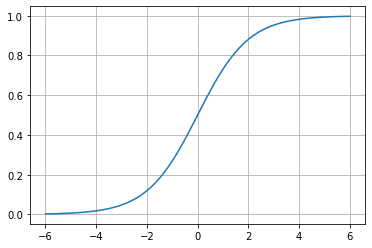

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-6,6,100)
y = 1 / (1 + np.exp(-x))

plt.plot(x,y)
plt.grid()
plt.show()

Ora, costruiamo una nuova funzione obiettivo che tenta di massimizzare la probabilità di una parola e il contesto siano nei dati del corpus se effettivamente è vero, e massimizzi la probabilità di una parola e il suo contesto se non è nel corpus e non sia vero.

Prendiamo un semplice approccio alla massima probabilità di queste due probabilità. (qui prendiamo $\sigma$ che rappresentano i parametri del modello e nel nostro caso sono $\mathcal{V}$ e $\mathcal{U}$)

